In [ ]:
#import necessary library
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

#drive's local file
sorbian_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.hsb'
german_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.de'

#read hsb sentences
with open(sorbian_path, 'r', encoding='utf-8') as f:
    sorbian_sentences = f.readlines()

#read german sentences
with open(german_path, 'r', encoding='utf-8') as f:
    german_sentences = f.readlines()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#dataset preprocess
def clean_and_align(sorbian_sentences, german_sentences, max_len=128):


    #清理空白和换行 remove empty sentences and /n
    sorbian_sentences = [s.strip() for s in sorbian_sentences if s.strip()]
    german_sentences = [s.strip() for s in german_sentences if s.strip()]

    #保持长度一致 keep align
    min_len = min(len(sorbian_sentences), len(german_sentences))
    sorbian_sentences = sorbian_sentences[:min_len]
    german_sentences = german_sentences[:min_len]

    #构建句对，过滤掉太长的句子 limitation of length of sentences
    filtered_pairs = []
    for s, g in zip(sorbian_sentences, german_sentences):
        if len(s.split()) < max_len and len(g.split()) < max_len:
            filtered_pairs.append((s, g))

    #去重（以句对为单位）remove duplicate sentences
    seen = set()
    unique_pairs = []
    for pair in filtered_pairs:
        if pair not in seen:
            seen.add(pair)
            unique_pairs.append(pair)

    #拆分成两个 list
    sorbian_clean, german_clean = zip(*unique_pairs) if unique_pairs else ([], [])

    return list(sorbian_clean), list(german_clean)

sorbian_sentences, german_sentences = clean_and_align(sorbian_sentences, german_sentences)


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# 加载 Glot500 模型 load Glot model from hugging face
tokenizer = AutoTokenizer.from_pretrained("cis-lmu/glot500-base")
model = AutoModel.from_pretrained("cis-lmu/glot500-base")
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")


# 编码函数（mean pooling）
def embed_sentences(sentences):
    embeddings = []
    device = "cuda" if torch.cuda.is_available() else "cpu" #use gpu
    for sent in tqdm(sentences):
        inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state.squeeze(0)  # shape: (seq_len, hidden_size)
        attention_mask = inputs['attention_mask'].squeeze(0)# mean pooling
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size())
        masked_hidden = last_hidden * mask_expanded
        sentence_embedding = masked_hidden.sum(0) / attention_mask.sum()
        embeddings.append(sentence_embedding.cpu().numpy())
    return np.array(embeddings)


# 分别生成两个语言的嵌入 generate embedding vectors
hsb_embeddings = embed_sentences(sorbian_sentences)
np.save("/content/drive/MyDrive/Colab Notebooks/glot500_hsb.npy", hsb_embeddings)
de_embeddings = embed_sentences(german_sentences)
np.save("/content/drive/MyDrive/Colab Notebooks/glot500_de.npy", de_embeddings)


KeyboardInterrupt: 

In [ ]:
!pip install kneed


In [ ]:
# 聚类 + 可视化 cluster + visualization
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator


drive.mount('/content/drive')

#使用 Elbow 方法选择最佳聚类数（K）
#Use Elbow and kneedle methods to select optimal number of clusters (K)
#silhouette score is not fitted cuz dataset too big-> running too long
def elbow_with_kneedle(embeddings: np.ndarray, k_range=range(2, 21), title="Elbow Curve with Auto K Detection") -> int:
    """
    使用 inertia 曲线 + Kneedle 方法自动检测最佳聚类数 K。
    Elbow method + KneeLocator to auto-detect best K.
    """
    inertias = []
    print("start calculating KMeans different K value under inertia...")
    for k in k_range:
        print(f"Fitting KMeans for k={k}")
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        inertias.append(kmeans.inertia_)

    # 自动检测“肘部”点  detect elbow point
    kneedle = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
    best_k = kneedle.elbow

    # 可视化 Elbow 曲线 plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, 'bo-', label="Inertia")
    if best_k:
        plt.axvline(x=best_k, color='red', linestyle='--', label=f"Best K = {best_k}")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.xticks(list(k_range))
    plt.show()

    if best_k:
        print(f"best K: {best_k}")
    else:
        print("no clear elbow found")

    return best_k

#kmeans方法用最佳的k值 kmeans using opimal k
def perform_kmeans(embeddings, n_clusters):
    print("Clustering in progress...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    print("Clustering completed.")
    return labels

#用pca降维画图 reduce high dimensions to low using PCA
def plot_clusters_pca(embeddings, labels, title):
    print("Running PCA dimensionality reduction...")
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    reduced = pca.fit_transform(embeddings)
    print("PCA completed. Generating plot...")

    # 可视化 visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.colorbar(scatter)
    plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


start calculating KMeans different K value under inertia...
Fitting KMeans for k=1
Fitting KMeans for k=2
Fitting KMeans for k=3
Fitting KMeans for k=4
Fitting KMeans for k=5
Fitting KMeans for k=6
Fitting KMeans for k=7
Fitting KMeans for k=8
Fitting KMeans for k=9
Fitting KMeans for k=10
Fitting KMeans for k=11
Fitting KMeans for k=12
Fitting KMeans for k=13
Fitting KMeans for k=14
Fitting KMeans for k=15
Fitting KMeans for k=16
Fitting KMeans for k=17
Fitting KMeans for k=18
Fitting KMeans for k=19
Fitting KMeans for k=20
Fitting KMeans for k=21
Fitting KMeans for k=22
Fitting KMeans for k=23
Fitting KMeans for k=24


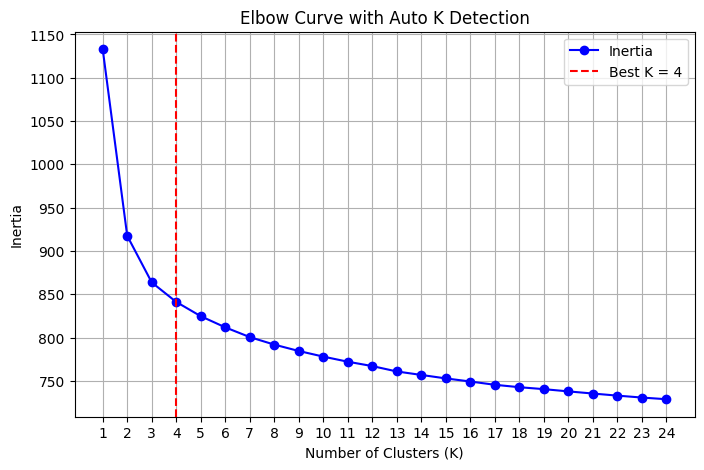

best K: 4
Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


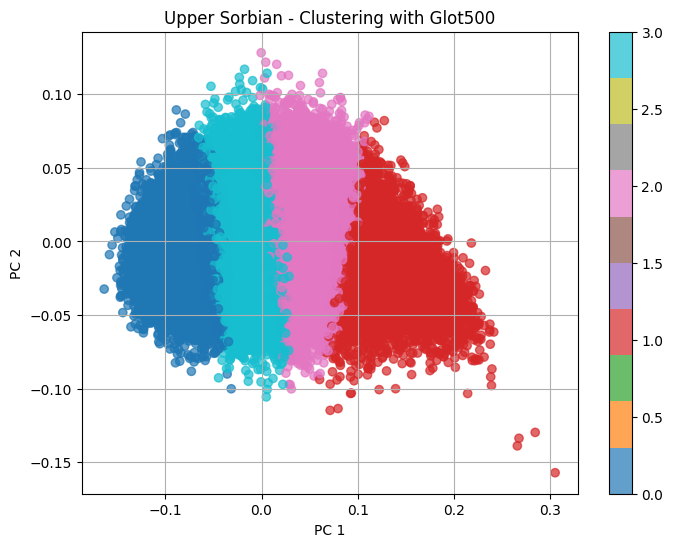

In [ ]:

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_hsb.npy")  # Upper Sorbian


# 判断最佳K determine optimal k--uppersobian
#The best k is 4
best_k_hsb = elbow_with_kneedle(hsb_embeddings, k_range=range(1, 25))

# 聚类 cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=best_k_hsb)

# 可视化 visualization
plot_clusters_pca(hsb_embeddings, hsb_labels, "Upper Sorbian - Clustering with Glot500")


start calculating KMeans different K value under inertia...
Fitting KMeans for k=1
Fitting KMeans for k=2
Fitting KMeans for k=3
Fitting KMeans for k=4
Fitting KMeans for k=5
Fitting KMeans for k=6
Fitting KMeans for k=7
Fitting KMeans for k=8
Fitting KMeans for k=9
Fitting KMeans for k=10
Fitting KMeans for k=11
Fitting KMeans for k=12
Fitting KMeans for k=13
Fitting KMeans for k=14
Fitting KMeans for k=15
Fitting KMeans for k=16
Fitting KMeans for k=17
Fitting KMeans for k=18
Fitting KMeans for k=19
Fitting KMeans for k=20
Fitting KMeans for k=21
Fitting KMeans for k=22
Fitting KMeans for k=23
Fitting KMeans for k=24


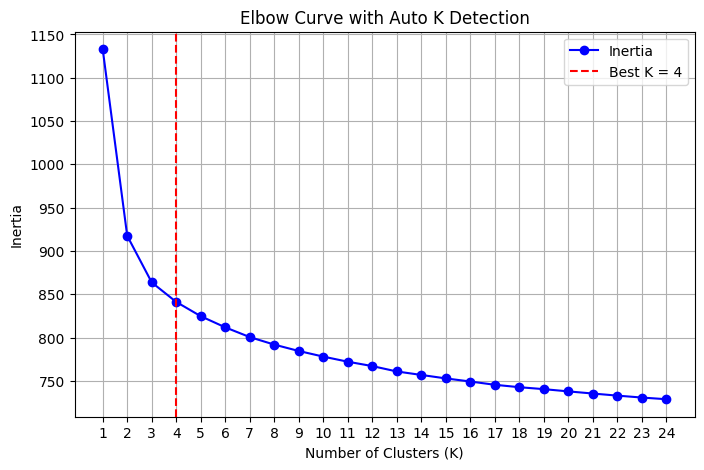

best K: 4
Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


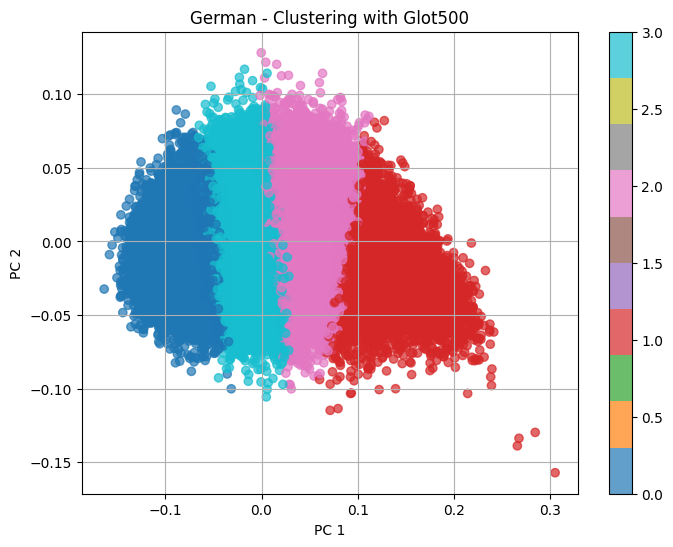

In [ ]:
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_hsb.npy")    # German

# de
#The best k is 4
best_k_de = elbow_with_kneedle(de_embeddings, k_range=range(1, 25))

de_labels = perform_kmeans(de_embeddings, n_clusters=best_k_de)

plot_clusters_pca(de_embeddings, de_labels, "German - Clustering with Glot500")

In [ ]:
from collections import defaultdict, Counter

# 将句子根据聚类标签分组 返回k个组 classify sentences by cluster number
def group_sentences_by_cluster(sentences, labels):
    clusters = defaultdict(list)
    for i, label in enumerate(labels):
        clusters[label].append(sentences[i])
    return clusters

# 根据高频词自动分配主题标签 name cluster using high-frequency words
def auto_assign_cluster_topics(keywords: dict):
    topic_labels = {}
    for cluster_id, word_freqs in keywords.items():
        label = word_freqs[0][0] if word_freqs else "Unknown"
        topic_labels[cluster_id] = label
    return topic_labels

# ✅ 主函数：构建每个 cluster 的“主题 + 示例句子”结构
def build_cluster_summary(sentences, labels, samples_per_cluster=5):
    """
    构建一个聚类摘要，包括主题标签和样本句子
    Build cluster summary: topic label + representative sentences
    输入：
      - sentences: 原始句子列表（与 labels 对应）
      - labels: 每个句子的聚类标签
      - samples_per_cluster: 每个 cluster 输出几个句子样本
    输出：
      - summary: dict[cluster_id] -> {topic, samples}
    """
    # 分组句子
    clusters = group_sentences_by_cluster(sentences, labels)

    # 统计关键词（每个 cluster 的 top 10）count top 10 word per cluster
    keywords = {}
    for cluster_id, sents in clusters.items():
        all_words = " ".join(sents).lower().split()
        keywords[cluster_id] = Counter(all_words).most_common(10)

    # 自动生成主题标签 generate labels
    topic_labels = auto_assign_cluster_topics(keywords)

    # 构建最终输出字典
    summary = {}
    for cluster_id in clusters:
        summary[cluster_id] = {
            "topic": topic_labels[cluster_id],
            "samples": clusters[cluster_id][:samples_per_cluster]
        }

    return summary


In [ ]:
summary = build_cluster_summary(sorbian_sentences, hsb_labels)

for cid, info in summary.items():
    print(f"\nCluster {cid} → Topic: {info['topic']}")
    for s in info['samples']:
        print("  ·", s)



Cluster 1 → Topic: so
  · Pos spi za durjemi.

  · Bórze je adwent zaso tu.

  · Miłoraženjo wědźa, wo čim rěču.

  · To je moja mać.

  · A potom tajke přikazy?!


Cluster 3 → Topic: a
  · To je minimalna suma za start projekta.

  · Zarjadowanje přeswědči z wysokim wědomostnym niwowom.

  · Nawopak je Serbski muzej ze swojimi pućowacymi wustajeńcami pola tu- a wukrajnych partnerow z hosćom.

  · Čłonojo towarstwa organizuja čitanja, koncerty, wustajeńcy a podobne.

  · Z tym měješe zajimcow ze serbskim wuměłstwom zeznajomić.


Cluster 0 → Topic: a
  · Za dobre zhromadne dźěło w knježerstwje njeje spomóžne stajnje na swoju wulkosć skedźbnjeć, Träger podšmórny.

  · Wona wudźěla slědźerske nadawki a organizuje dalše naprawy, kiž so jej k docpěću swojich zaměrow přihódne zdadźa.

  · Smy spytali, wšitke mocy koncentrować a towarstwa do skupinow Domowiny z wosobinskim sobustawstwom přeměnić.

  · Nowe naprawy maja so na hospodarske lěto wusměrjene nadźěłać abo wudospołnić.

  · Serbska 

In [ ]:
summary = build_cluster_summary(german_sentences, de_labels)

for cid, info in summary.items():
    print(f"\nCluster {cid} → Topic: {info['topic']}")
    for s in info['samples']:
        print("  ·", s)


Cluster 1 → Topic: ich
  · Der Hund schläft hinter der Türe.

  · Bald ist der Advent wieder da.

  · Die Mühlroser wissen, wovon ich rede.

  · Das ist meine Mutter.

  · Und dann solche Befehle?!


Cluster 3 → Topic: die
  · Das ist die Mindestsumme für den Start des Projekts.

  · Die Veranstaltung überzeugte mit hohem wissenschaftlichem Niveau.

  · Umgekehrt ist das Sorbische Museum mit seinen Wanderausstellungen bei in- und ausländischen Partner zu Gast.

  · Die Mitglieder des Vereins organisieren Lesungen, Konzerte, Ausstellungen und Ähnliches.

  · Damit sollte sie Interessierte mit der sorbischen Kunst bekannt machen.


Cluster 0 → Topic: der
  · Für eine gute Zusammenarbeit in der Regierung ist es nicht zuträglich immer auf die eigene Größe hinzuweisen, unterstrich Träger.

  · Sie erteilt Forschungsaufträge und organisiert weitere Maßnahmen, welche zur Erreichung ihrer Ziele förderlich erscheinen.

  · Wir haben versucht, alle Kräfte zu konzentrieren und Vereine in Gruppen

In [ ]:
from collections import defaultdict, Counter

def compare_cross_lingual_cluster_consistency(hsb_labels, de_labels, hsb_sentences, de_sentences):
    """
    比较 Upper Sorbian 的每个聚类中句子在 German 中的聚类分布。
    Compare how consistently each Upper Sorbian cluster maps into German clusters.
    返回：
    - report: dict — 每个 Upper Sorbian cluster 的映射分析，包括：
        - 映射最多的 German cluster ID
        - 一致性占比（百分比形式）
        - 各个 German cluster 的分布统计
     Returns:
    - report: dict — mapping statistics per Upper Sorbian cluster:
        - 'top_german_cluster': the German cluster with the most aligned sentences
        - 'consistency_ratio': proportion of sentences in that dominant cluster
        - 'distribution': full count of how aligned sentences are distributed across German clusters
    """
    cluster_map = defaultdict(list)  # 存储：Upper Sorbian cluster_id -> index列表
                                     # save：Upper Sorbian cluster_id -> index list
    for idx, label in enumerate(hsb_labels):
        cluster_map[label].append(idx)

    report = {}

    for cluster_id, indices in cluster_map.items():
        # 找出对应德语句子的聚类标签 find cluster of corresponding german sentences
        german_cluster_ids = [de_labels[i] for i in indices]
        german_counts = Counter(german_cluster_ids)
        total = len(german_cluster_ids)

        # 找到最常出现的 German cluster（占比最高）find most common cluster
        top_cluster, top_count = german_counts.most_common(1)[0]
        ratio = top_count / total

        # 构建报告
        report[cluster_id] = {
            "top_german_cluster": top_cluster,
            "consistency_ratio": round(ratio, 2),
            "distribution": dict(german_counts),

        }

    return report
def describe_crosslingual_cluster_mapping(report: dict):
    """
    输出 Upper Sorbian 每个聚类在 German 中的聚类分布描述（用于人类阅读）
    Print human-readable description of how each Upper Sorbian cluster maps to German clusters

    参数：
    - report: dict，来自 compare_cross_lingual_cluster_consistency() 的输出

    功能：
    - 不强调 cluster ID 的语义一致性
    - 更清楚地表述“映射到了哪个 German cluster（占比多少）”
    - 显示每个分布（distribution）、Upper Sorbian 示例句、德语翻译对照句
    """
    for cid, info in sorted(report.items()):
        print(f"\n Upper Sorbian Cluster {cid}:")
        print(f"  → Most mapped to German Cluster {info['top_german_cluster']} "
              f"({info['consistency_ratio']*100:.1f}% of sentences)")
        print(f"  → Full German cluster distribution: {info['distribution']}")



In [ ]:
report = compare_cross_lingual_cluster_consistency(hsb_labels, de_labels, sorbian_sentences, german_sentences)
describe_crosslingual_cluster_mapping(report)  # 用更合理语言描述映射结果



 Upper Sorbian Cluster 0:
  → Most mapped to German Cluster 0 (100.0% of sentences)
  → Full German cluster distribution: {np.int32(0): 17386}

 Upper Sorbian Cluster 1:
  → Most mapped to German Cluster 1 (100.0% of sentences)
  → Full German cluster distribution: {np.int32(1): 7436}

 Upper Sorbian Cluster 2:
  → Most mapped to German Cluster 2 (100.0% of sentences)
  → Full German cluster distribution: {np.int32(2): 15628}

 Upper Sorbian Cluster 3:
  → Most mapped to German Cluster 3 (100.0% of sentences)
  → Full German cluster distribution: {np.int32(3): 19550}
